✅ Normalized dataset is ready!
Found 13685 images belonging to 3 classes.
Found 3419 images belonging to 3 classes.
Epoch 1/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1316s 3s/step - accuracy: 0.4319 - loss: 1.0327 - val_accuracy: 0.4370 - val_loss: 1.0124
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1238s 3s/step - accuracy: 0.4438 - loss: 1.0246 - val_accuracy: 0.4844 - val_loss: 1.0100
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1243s 3s/step - accuracy: 0.4581 - loss: 1.0241 - val_accuracy: 0.4235 - val_loss: 1.0066
Epoch 4/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1260s 3s/step - accuracy: 0.4659 - loss: 1.0060 - val_accuracy: 0.4873 - val_loss: 1.0065
Epoch 5/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1238s 3s/step - accuracy: 0.4628 - loss: 1.0150 - val_accuracy: 0.4788 - val_loss: 1.0034


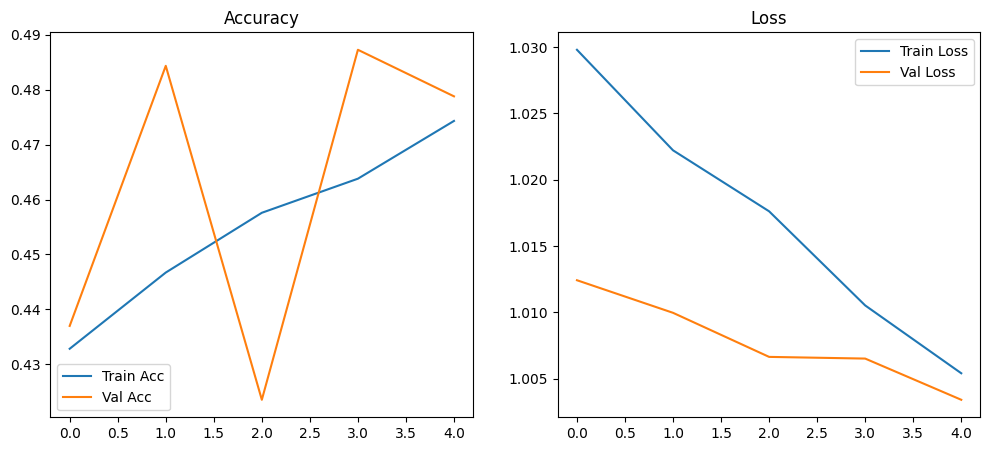

107/107 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step
🔍 Classification Report:

              precision    recall  f1-score   support

   1NonCOVID       0.48      0.74      0.58      1378
      2COVID       0.48      0.40      0.44      1518
        3CAP       0.00      0.00      0.00       523

    accuracy                           0.48      3419
   macro avg       0.32      0.38      0.34      3419
weighted avg       0.41      0.48      0.43      3419



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


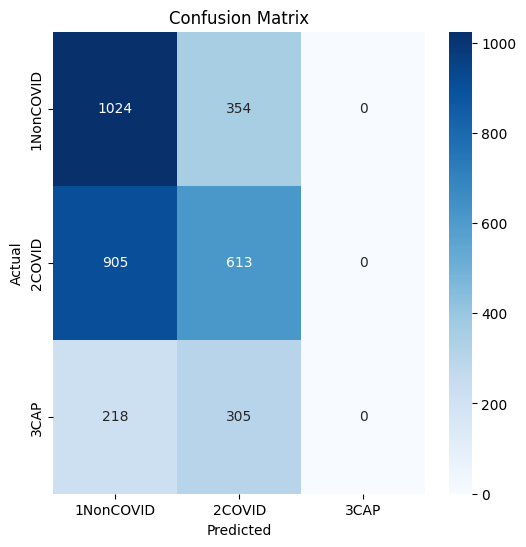

107/107 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.6771 - loss: 0.8420
✅ Final Accuracy: 0.4788
❌ Error Rate: 52.12%


In [ ]:
# ✅ Unzip Normalized Dataset
import zipfile

with zipfile.ZipFile("normalized_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/normalized_dataset")

print("✅ Normalized dataset is ready!")

# 🧪 Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 📁 Dataset paths (use resized 160x160 images)
data_path = "/content/normalized_dataset/curated_data"
img_size = 160
batch_size = 32

# 🔄 Data generators with normalization
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

# 🔧 EfficientNetB3 model with smaller input and dropout
base_model = EfficientNetB3(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
base_model.trainable = False  # freeze base to train faster

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# 🚀 Compile with smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 🏋️‍♂️ Train for fewer epochs (can later fine-tune)
history = model.fit(train_data, validation_data=val_data, epochs=5)

# 💾 Save model
model.save("EfficientNetB3_Optimized.h5")

# 📉 Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

# 📊 Evaluation
val_data.reset()
predictions = model.predict(val_data, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

print("🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 📉 Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 📌 Accuracy & Error
final_loss, final_acc = model.evaluate(val_data)
error_rate = (1 - final_acc) * 100
print(f"✅ Final Accuracy: {final_acc:.4f}")
print(f"❌ Error Rate: {error_rate:.2f}%")
